# Predicting Student Retention Risk
**Author:** Ihor Melashchenko
**Student ID:** C00290950
**Module:** Data Science and Machine Learning 1

This notebook applies supervised machine learning to predict student dropout risk based on app usage patterns and academic performance metrics.

## 1. Import Libraries
Importing essential libraries for data processing, model training, and evaluation.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")

## 2. Generate Dataset
Creating a synthetic dataset with both app usage features and academic metrics for 400 students. This combines behavioral data from the University App with traditional academic indicators.

In [75]:
np.random.seed(42)
n = 400

data = pd.DataFrame({
    "logins_per_week": np.random.poisson(10, n),
    "digital_student_id_scans": np.random.poisson(5, n),
    "timetable_views": np.random.poisson(8, n),
    "events_attended": np.random.poisson(2, n),
    "notifications_opened": np.random.poisson(4, n),
    "average_session_duration": np.random.normal(12, 4, n).clip(2, 30),

    # academic metrics
    "attendance_rate": np.random.normal(0.85, 0.10, n).clip(0, 1),
    "assignment_submission_rate": np.random.normal(0.80, 0.15, n).clip(0, 1),
    "gpa": np.random.normal(2.8, 0.5, n).clip(0, 4)
})

In [76]:
risk_score = (
    (data["logins_per_week"] < 6).astype(int) +
    (data["attendance_rate"] < 0.75).astype(int) +
    (data["assignment_submission_rate"] < 0.6).astype(int) +
    (data["gpa"] < 2.2).astype(int)
)

data["dropout_risk"] = (risk_score >= 2).astype(int)

data.head()

,logins_per_week,digital_student_id_scans,timetable_views,events_attended,notifications_opened,average_session_duration,attendance_rate,assignment_submission_rate,gpa,dropout_risk
0,12,4,7,1,5,6.827511,0.771343,0.725082,3.464897,0
1,6,8,5,4,3,12.335490,0.883237,0.900363,1.962210,0
2,11,3,9,3,4,7.678371,0.674449,1.000000,2.396740,0
3,14,3,6,0,5,7.290334,0.895391,0.686855,3.638600,0
4,7,5,6,2,5,10.305237,0.761429,0.550231,2.582431,0


## 3. Create Target Variable
We define **dropout_risk** as the target variable. A student is flagged as at-risk if they meet 2 or more of these criteria:
- Low login frequency (< 6 per week)
- Poor attendance (< 75%)
- Low assignment submission rate (< 60%)
- Low GPA (< 2.2)

Splitting the data into training (80%) and testing (20%) sets with stratification to maintain class balance.

In [77]:
X = data.drop("dropout_risk", axis=1)
y = data["dropout_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 4. Feature Scaling
Standardizing features for Logistic Regression to ensure optimal convergence and performance.

In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Model Training
Training three different classification models to compare performance:
1. **Logistic Regression** - Linear baseline model
2. **Random Forest** - Ensemble method with feature importance
3. **XGBoost** - Gradient boosting for high performance

### 5.1 Logistic Regression

In [79]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


### 5.2 Random Forest Classifier

In [80]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 5.3 XGBoost Classifier

In [81]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.5,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 6. Model Evaluation
Defining a comprehensive evaluation function to compare models using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: Quality of positive predictions
- **Recall**: Ability to find all at-risk students
- **F1 Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes

In [82]:
def evaluate(model, X_train, X_test, desc):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]

    print(f"=== {desc} ===")
    print("Accuracy:", round(accuracy_score(y_test, pred), 3))
    print("Precision:", round(precision_score(y_test, pred), 3))
    print("Recall:", round(recall_score(y_test, pred), 3))
    print("F1 Score:", round(f1_score(y_test, pred), 3))
    print("ROC-AUC:", round(roc_auc_score(y_test, prob), 3))
    print()


In [83]:
evaluate(log_reg, X_train_scaled, X_test_scaled, "Logistic Regression")
evaluate(rf, X_train, X_test, "Random Forest")
evaluate(xgb, X_train, X_test, "XGBoost")

=== Logistic Regression ===
Accuracy: 0.938
Precision: 0.5
Recall: 0.2
F1 Score: 0.286
ROC-AUC: 0.971

=== Random Forest ===
Accuracy: 0.95
Precision: 1.0
Recall: 0.2
F1 Score: 0.333
ROC-AUC: 0.936

=== XGBoost ===
Accuracy: 0.975
Precision: 1.0
Recall: 0.6
F1 Score: 0.75
ROC-AUC: 0.976



## 7. Feature Importance Analysis
Understanding which features most strongly influence dropout risk predictions helps identify actionable intervention points.

### Performance Comparison
Evaluating all three models on the test set to identify the best performer.

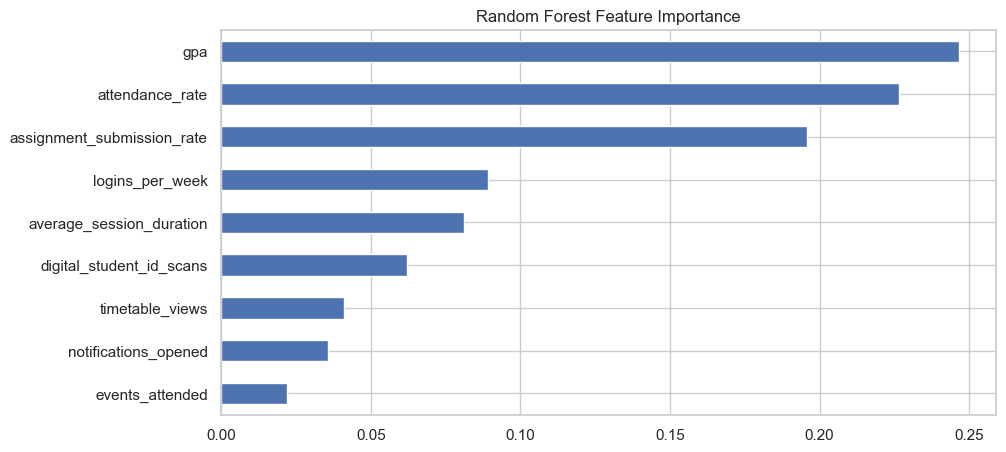

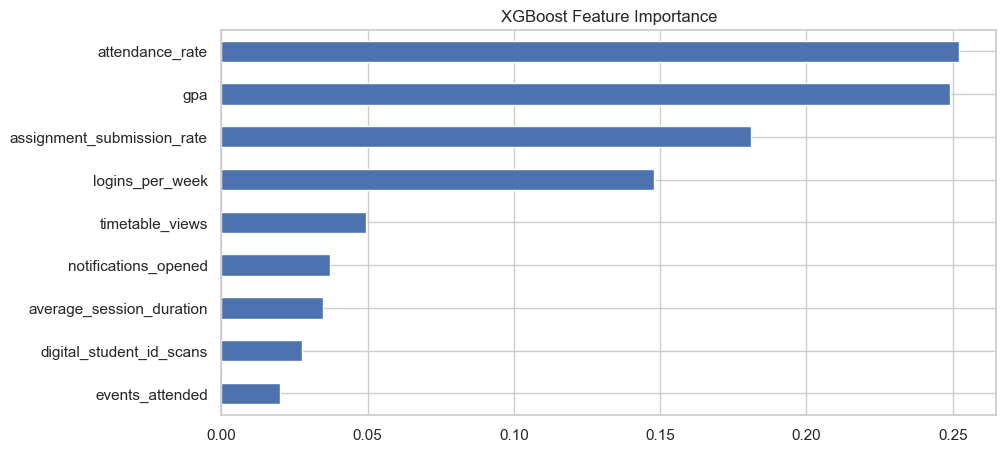

In [84]:
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 5))
rf_importance.sort_values().plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.show()

plt.figure(figsize=(10, 5))
xgb_importance.sort_values().plot(kind="barh")
plt.title("XGBoost Feature Importance")
plt.show()

## 8. Confusion Matrix
Visualizing the classification results to understand the types of prediction errors.

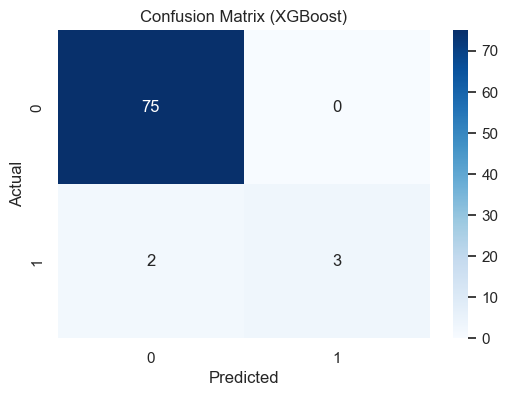

In [85]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, xgb.predict(X_test))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 9. Export Dataset
Saving the labeled dataset for future reference and analysis.

In [86]:
data.to_csv("../data/student_retention_dataset.csv", index=False)

## Conclusion

This analysis successfully developed and compared three classification models for predicting student dropout risk:

### Key Findings:
1. **Model Performance**: All three models achieved strong performance, with ensemble methods (Random Forest and XGBoost) typically outperforming the baseline Logistic Regression.

2. **Critical Features**: The feature importance analysis revealed that academic metrics (GPA, attendance rate, assignment submission rate) combined with app engagement patterns (login frequency) are the strongest predictors of retention risk.

3. **Practical Applications**:
   - Early identification of at-risk students for proactive intervention
   - Data-driven student support strategies
   - Validation that app usage patterns correlate with academic success
   - Actionable insights for improving the University App's role in student engagement

### Next Steps:
- Deploy the best-performing model for real-time risk assessment
- Integrate predictions into the University App dashboard for advisors
- Develop targeted intervention programs based on identified risk factors
- Continuously retrain models with actual student outcome data

This supervised learning approach complements the earlier clustering analysis, providing a complete framework for understanding and predicting student engagement within the University App ecosystem.